In [1]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
import features_utility as featutil

## File Details - Light GBM Regression All cols

This is a Candidate for being used in an Ensemble. 
Characteristicts:
* Light GBM Regression Algorithm
* All columns, including Review Counts
* Todo: use optimised parameters for Light GBM Regression


In [2]:
filePrefix = "A3_050_lgbm_regression_allcols"
baseDataDir = "C:/Development/Data/COSC2670/Assignment3/A3data/"
subrunDir = "subruns/"
writeSubRunFile = True
seed = databasic.get_random_seed()

In [3]:
# RowID  BeerID  ReviewerID  BeerName  BeerType  Label
# df_train = pd.read_csv(baseDataDir + 'train_500k.tsv',sep='\t',
df_train = pd.read_csv(baseDataDir + 'train.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_train.head(10)

# df_vali = pd.read_csv(baseDataDir + 'vali_500k.tsv',sep='\t',
df_vali = pd.read_csv(baseDataDir + 'val.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_vali.head(10)


,RowID,BeerID,ReviewerID,BeerName,BeerType,rating
0,22,12300,2634,Rauch Ür Bock,Rauchbier,4.0
1,27,12300,5634,Rauch Ür Bock,Rauchbier,4.5
2,28,12300,3544,Rauch Ür Bock,Rauchbier,4.5
3,40,12300,6521,Rauch Ür Bock,Rauchbier,4.0
4,43,12300,10177,Rauch Ür Bock,Rauchbier,4.5
5,48,12300,2907,Rauch Ür Bock,Rauchbier,3.5
6,49,12300,1532,Rauch Ür Bock,Rauchbier,4.0
7,50,12300,3452,Rauch Ür Bock,Rauchbier,3.5
8,59,12300,6861,Rauch Ür Bock,Rauchbier,4.0
9,64,6699,6401,Caldera Pale Ale,American Pale Ale (APA),4.5


Add the Review Count columns for Reviewers and Beers to both the Train and Validation sets

In [4]:
df_train = featutil.addReviewerReviewCount(df_train)
df_train = featutil.addBeerReviewCount(df_train)

df_vali = featutil.addReviewerReviewCount(df_vali)
df_vali = featutil.addBeerReviewCount(df_vali)


In [5]:
print(df_train.shape)
df_train.sort_values("ReviewerID").head(10)


(845008, 8)


,RowID,BeerID,ReviewerID,BeerName,BeerType,rating,ReviewerReviewCount,BeerReviewCount
272637,1306887,6799,1,Wild Blue (Blueberry Lager),Fruit / Vegetable Beer,2.0,189,240
614045,1316066,1558,1,Anchor Summer Beer,American Pale Wheat Ale,4.0,189,308
552427,69111,1513,1,Castle Lager,American Adjunct Lager,2.5,189,62
685869,332234,10430,1,Belvidere Big IPA,American Double / Imperial IPA,3.0,189,45
526379,408111,1596,1,Tröegs Pale Ale,American Pale Ale (APA),4.5,189,338
83331,891907,678,1,Double Bastard Ale,American Strong Ale,4.5,189,1077
51391,31809,2790,1,Founders Centennial IPA,American IPA,4.0,189,818
83332,891955,678,1,Double Bastard Ale,American Strong Ale,3.5,189,1077
159461,868116,71,1,Arrogant Bastard Ale,American Strong Ale,4.5,189,1509
559227,235959,4271,1,Southampton Grand Cru,Belgian Strong Pale Ale,5.0,189,176


In [6]:
# RowID BrewerID ABV DayofWeek Month DayofMonth Year TimeOfDay Gender Birthday Text Lemmatized POS_Tag
# df_features = pd.read_csv(baseDataDir + 'features_500k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
df_features = pd.read_csv(baseDataDir + 'features_200k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
                                                                 'DayofMonth','Year','TimeOfDay','Gender',
                                                                 'Birthday','Text','Lemmatized','POS_Tag'])

df_features.head()

,RowID,BrewerID,ABV,DayofWeek,Month,DayofMonth,Year,TimeOfDay,Gender,Birthday,Text,Lemmatized,POS_Tag
0,18,1075,7.4,Mon,Jan,2,2012,15:20:04,Male,unknown,Pours a murky light brown with a 1 inch fizzy ...,pour a murky light brown with a 1 inch fizzy t...,VBZ DT JJ NN JJ IN DT CD NN JJ NN NN WDT VBZ I...
1,19,1075,7.4,Sun,Jan,1,2012,06:46:52,Male,unknown,Faint sudsy head with some with some dissipati...,faint sudsy head with some with some dissipate...,NN JJ NN IN DT IN DT VBG JJ NN . JJ JJ NN . DT...
2,20,1075,7.4,Tue,Nov,29,2011,05:51:44,Male,unknown,A new arrival to the West TN area ... Pours qu...,a new arrival to the West TN area ... pour qui...,"DT JJ NN IN DT NNP NNP NN , VBZ PDT DT NN JJR ..."
3,21,1075,7.4,Sat,Nov,5,2011,22:59:57,Male,unknown,Sampled 10/30/11 - Transferring the notes . A ...,sample 10/30/11 - transfer the note . a ruby p...,VBN CD HYPH VBG DT NNS . DT NN VBP IN DT NN NN...
4,22,1075,7.4,Tue,Nov,1,2011,20:40:21,Male,"Oct 14, 1983",This is my first rauchbier . Pours a burnt amb...,this be my first rauchbier . pour a burn amber...,DT VBZ PRP$ JJ NN . VBZ DT VBN NN . JJ NN . NN...


In [7]:
colsToUse = ["RowID", "BrewerID", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay", "Birthday"]

# Find the feature records that match the training and validation data and join them together
dfFullData = df_train.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")
dfFullDataVali = df_vali.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")

dfFullData.head()

,RowID,BeerID,ReviewerID,BeerName,BeerType,rating,ReviewerReviewCount,BeerReviewCount,RowIDFeat,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay,Birthday
0,19,12300,10635,Rauch Ür Bock,Rauchbier,4.0,200,23,37,1075,7.4,Mon,23,May,2011,Male,15:36:28,unknown
1,21,12300,6547,Rauch Ür Bock,Rauchbier,4.5,10,23,40,1075,7.4,Mon,16,May,2011,Male,00:31:46,unknown
2,23,12300,9789,Rauch Ür Bock,Rauchbier,4.5,164,23,42,1075,7.4,Sun,10,Apr,2011,unknown,12:17:26,unknown
3,24,12300,7372,Rauch Ür Bock,Rauchbier,5.0,432,23,43,1075,7.4,Wed,30,Mar,2011,Male,14:08:00,unknown
4,25,12300,1302,Rauch Ür Bock,Rauchbier,4.5,500,23,45,1075,7.4,Thu,24,Mar,2011,Male,14:07:00,"Jul 25, 1984"


In [8]:
# Remove the duplicated Row ID, also remove Beer Name at this point, we're nt using it
df_train_data = dfFullData.drop(['RowIDFeat', "BeerName"],axis=1)
df_vali_data = dfFullDataVali.drop(['RowIDFeat', "BeerName"],axis=1)

df_train_data.head()

,RowID,BeerID,ReviewerID,BeerType,rating,ReviewerReviewCount,BeerReviewCount,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay,Birthday
0,19,12300,10635,Rauchbier,4.0,200,23,1075,7.4,Mon,23,May,2011,Male,15:36:28,unknown
1,21,12300,6547,Rauchbier,4.5,10,23,1075,7.4,Mon,16,May,2011,Male,00:31:46,unknown
2,23,12300,9789,Rauchbier,4.5,164,23,1075,7.4,Sun,10,Apr,2011,unknown,12:17:26,unknown
3,24,12300,7372,Rauchbier,5.0,432,23,1075,7.4,Wed,30,Mar,2011,Male,14:08:00,unknown
4,25,12300,1302,Rauchbier,4.5,500,23,1075,7.4,Thu,24,Mar,2011,Male,14:07:00,"Jul 25, 1984"


In [9]:
print(df_train_data.shape)
print(df_vali_data.shape)

(106546, 16)
(35089, 16)


In [10]:
colsToUse.append("BeerType")
colsToUse.append("ReviewerReviewCount")
colsToUse.append("BeerReviewCount")

considerCol = {}

# Initialize them all to True, use all the cols
for colName in colsToUse:
  considerCol[colName] = True

# "RowID", "BrewerID", "BeerType", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay"
# Disable any column we want

# Usually always use Year and REview Counts
# considerCol["Year"] = False
# considerCol["ReviewerReviewCount"] = False
# considerCol["BeerReviewCount"] = False

# Beer Context Columns
# considerCol["ABV"] = False
# considerCol["BrewerID"] = False
# considerCol["BeerType"] = False

# Consumer Context Columns
# considerCol["DayofWeek"] = False
# considerCol["DayofMonth"] = False
# considerCol["Month"] = False
# considerCol["TimeOfDay"] = False
# considerCol["Gender"] = False
# considerCol["Birthday"] = False


In [11]:
if considerCol["ABV"] == False:
  del df_train_data["ABV"]
  del df_vali_data["ABV"]
else:
  df_train_data = featutil.fixNullABV(df_train_data)
  df_vali_data = featutil.fixNullABV(df_vali_data)

In [12]:
if considerCol["BrewerID"] == False:
  del df_train_data["BrewerID"]
  del df_vali_data["BrewerID"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "BrewerID")


c:\Development\COSC2670\Assignment3\utilities\dataframe_utility.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_combined.columns = df_combined.columns.str.replace(" ", "").str.replace("/", "").str.replace("-", "") \


In [13]:
if considerCol["BeerType"] == False:
  del df_train_data["BeerType"]
  del df_vali_data["BeerType"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "BeerType")

In [14]:
if considerCol["Gender"] == False:
  del df_train_data["Gender"]
  del df_vali_data["Gender"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "Gender")

In [15]:
if considerCol["DayofWeek"] == False:
  del df_train_data["DayofWeek"]
  del df_vali_data["DayofWeek"]
else: 
  df_train_data = featutil.formatDayOfWeek(df_train_data)
  df_vali_data = featutil.formatDayOfWeek(df_vali_data)

In [16]:
if considerCol["Month"] == False:
  del df_train_data["Month"]
  del df_vali_data["Month"]
else: 
  df_train_data = featutil.formatMonth(df_train_data)
  df_vali_data = featutil.formatMonth(df_vali_data)

In [17]:
if considerCol["DayofMonth"] == False:
  del df_train_data["DayofMonth"]
  del df_vali_data["DayofMonth"]

In [18]:
if considerCol["Year"] == False:
  del df_train_data["Year"]
  del df_vali_data["Year"]

In [19]:
if considerCol["TimeOfDay"] == False:
  del df_train_data["TimeOfDay"]
  del df_vali_data["TimeOfDay"]
else: 
  df_train_data = featutil.formatTimeToSec(df_train_data)
  df_vali_data = featutil.formatTimeToSec(df_vali_data)

In [20]:
if considerCol["Birthday"] == False:
  del df_train_data["Birthday"]
  del df_vali_data["Birthday"]
else: 
  df_train_data = featutil.convertBirthdayToAge(df_train_data)
  df_vali_data = featutil.convertBirthdayToAge(df_vali_data)

In [21]:
if considerCol["ReviewerReviewCount"] == False:
  del df_train_data["ReviewerReviewCount"]
  del df_vali_data["ReviewerReviewCount"]

In [22]:
if considerCol["BeerReviewCount"] == False:
  del df_train_data["BeerReviewCount"]
  del df_vali_data["BeerReviewCount"]

In [23]:
print(df_train_data.shape)
print(df_vali_data.shape)

df_train_data.head()

(106546, 403)
(35089, 403)


,RowID,BeerID,ReviewerID,rating,ReviewerReviewCount,BeerReviewCount,ABV,DayofWeek,DayofMonth,Month,...,BeerType_SmokedBeer,BeerType_Tripel,BeerType_ViennaLager,BeerType_Weizenbock,BeerType_Wheatwine,BeerType_WinterWarmer,BeerType_Witbier,Gender_Female,Gender_Male,Gender_unknown
0,19,12300,10635,4.0,200,23,7.4,1,23,5,...,0,0,0,0,0,0,0,0,1,0
1,21,12300,6547,4.5,10,23,7.4,1,16,5,...,0,0,0,0,0,0,0,0,1,0
2,23,12300,9789,4.5,164,23,7.4,7,10,4,...,0,0,0,0,0,0,0,0,0,1
3,24,12300,7372,5.0,432,23,7.4,3,30,3,...,0,0,0,0,0,0,0,0,1,0
4,25,12300,1302,4.5,500,23,7.4,4,24,3,...,0,0,0,0,0,0,0,0,1,0


In [24]:
df_vali_data.head()

,RowID,BeerID,ReviewerID,rating,ReviewerReviewCount,BeerReviewCount,ABV,DayofWeek,DayofMonth,Month,...,BeerType_SmokedBeer,BeerType_Tripel,BeerType_ViennaLager,BeerType_Weizenbock,BeerType_Wheatwine,BeerType_WinterWarmer,BeerType_Witbier,Gender_Female,Gender_Male,Gender_unknown
0,22,12300,2634,4.0,19,9,7.4,6,14,5,...,0,0,0,0,0,0,0,0,0,1
1,27,12300,5634,4.5,48,9,7.4,4,10,2,...,0,0,0,0,0,0,0,0,0,1
2,28,12300,3544,4.5,227,9,7.4,5,10,12,...,0,0,0,0,0,0,0,0,0,1
3,40,12300,6521,4.0,81,9,5.5,4,27,8,...,0,0,0,0,0,0,0,0,1,0
4,43,12300,10177,4.5,58,9,5.5,1,10,8,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# free up the memory
del dfFullData
del dfFullDataVali

In [26]:
# Get all the columns
col_names = df_train_data.columns

idCols = ['RowID','BeerID','ReviewerID']
feature_cols =  col_names.drop(['RowID','BeerID','ReviewerID','rating' ])
target_col = 'rating'

# Create the sub data sets of the features and the target
dfTrainIds = df_train_data[idCols]
dfTrainFeatures = df_train_data[feature_cols]
dfTrainTarget = df_train_data[target_col]

dfValiIds = df_vali_data[idCols]
dfValiFeatures = df_vali_data[feature_cols]
dfValiTarget = df_vali_data[target_col]


In [27]:
dfValiIds.head()

,RowID,BeerID,ReviewerID
0,22,12300,2634
1,27,12300,5634
2,28,12300,3544
3,40,12300,6521
4,43,12300,10177


In [28]:
print(dfTrainFeatures.shape)
dfTrainFeatures.head()

(106546, 399)


,ReviewerReviewCount,BeerReviewCount,ABV,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Birthday,BrewerID_1,...,BeerType_SmokedBeer,BeerType_Tripel,BeerType_ViennaLager,BeerType_Weizenbock,BeerType_Wheatwine,BeerType_WinterWarmer,BeerType_Witbier,Gender_Female,Gender_Male,Gender_unknown
0,200,23,7.4,1,23,5,2011,56188,0,0,...,0,0,0,0,0,0,0,0,1,0
1,10,23,7.4,1,16,5,2011,1906,0,0,...,0,0,0,0,0,0,0,0,1,0
2,164,23,7.4,7,10,4,2011,44246,0,0,...,0,0,0,0,0,0,0,0,0,1
3,432,23,7.4,3,30,3,2011,50880,0,0,...,0,0,0,0,0,0,0,0,1,0
4,500,23,7.4,4,24,3,2011,50820,37,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
# all cols best params
# {'learning_rate': 0.012319449084467107, 'num_leaves': 117, 'max_depth': 22, 'n_estimators ': 295}
# Consumer Context best params
# 

# No tuning
# model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed)

model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed
    ,learning_rate=0.012319449084467107, num_leaves = 117, max_depth = 22, n_estimators = 295
  )

model.fit(X=dfTrainFeatures, y=dfTrainTarget, )

LGBMRegressor(learning_rate=0.012319449084467107, max_depth=22, metric='mae',
              n_estimators=295, num_leaves=117, objective='regression_l1',
              random_state=167559)

In [30]:
# Use the model to predict against our validation data
test_predicted = model.predict(dfValiFeatures)
test_predicted[0:100]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

<AxesSubplot:>

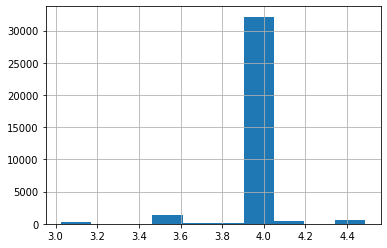

In [31]:
dfPredicted = pd.DataFrame({"Predict": test_predicted})
dfPredicted['Predict'].hist(bins=10)


In [32]:
mae = mean_absolute_error(dfValiTarget, test_predicted)

print("Average MAE: " + str(mae))
print("analyse_maes.append(" + str(mae) + ")")

Average MAE: 0.4529137775468108
analyse_maes.append(0.4529137775468108)


In [33]:

# print("Run: " + filePrefix)
# # Log of Results
# analyse_maes = []

# print("Average MAE over all tests: " + str(np.mean(analyse_maes)))

# Make sure it's predicting floats
# dfPredicted["Predict"].drop_duplicates()

Write to a subrun file

In [34]:
dfPredicted = pd.concat([dfValiIds.reset_index(), dfPredicted], axis=1).drop(columns="index")

if writeSubRunFile:
  dfPredicted.to_csv(subrunDir + filePrefix + "_subrun.csv", index=False)

print("Average MAE: " + str(mae))
print(dfPredicted.shape)
dfPredicted.sort_values("RowID").head(20)


Average MAE: 0.4529137775468108
(35089, 4)


,RowID,BeerID,ReviewerID,Predict
0,22,12300,2634,4.0
1,27,12300,5634,4.0
2,28,12300,3544,4.0
3,40,12300,6521,4.0
4,43,12300,10177,4.0
5,48,12300,2907,4.0
6,49,12300,1532,4.0
7,50,12300,3452,4.0
8,59,12300,6861,4.0
8503,64,6699,6401,4.0


# Summary

No Param Tuning
* all cols inc Review Counts
* MAE: 0.45314547068864475

All Cols Best Params
* all cols inc Review Counts
* Average MAE: 0.4476805595515732
